# Time Series classification of Aerodynamics
The boundary layer on an airfoil can be in two states, Laminar or Turbulent. Visually this switch is quite easy to see, for the aerodynamics muggles, the turbulent boundary layer state with show up on the time series data from the microphone as very turbulent(or volatile if you are from the finance world). 
Other ways to solve this problem include
- Traditional signal processing tricks that can extract such a change over of course. 
- Bayesian switch point analysis with a flexible number of switch points would also work. 
- The auto-regressive type models<br>
But I wanted to try my hand at getting a time series model in torch working, so here we are. 

In [4]:
import torch 
import pickle
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set up Model
One layer LSTM to multi layer fully conencted.
Sigmoid on the out layer as it is a classification problem. 
More layers can be enabled but 91% Validation error is possible with our the second lstm and extra fc layers. 

In [7]:
class Classifier(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(Classifier,self).__init__()
        
        self.lstm1 = nn.LSTMCell(input_size, hidden_size)
        #self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.layer1 = nn.Linear(hidden_size,hidden_size)
        self.ReLU1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size,hidden_size)
        self.ReLU2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size,hidden_size)
        self.ReLU3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size,output_size)
        self.Sigmoid = nn.Sigmoid()
    def forward(self,input):
        #print(input.shape)
        h_out = torch.zeros(input.size(0), 6).cuda()
        c_out = torch.zeros(input.size(0), 6).cuda()
        #h2_out = torch.zeros(input.size(0), 6).cuda()
        #c2_out = torch.zeros(input.size(0), 6).cuda()
        
        h_out, c_out = self.lstm1(input,(h_out, c_out))
        #h2_out, c2_out = self.lstm2(h_out,(h2_out, c2_out))
        #out = self.lstm2(out)
        out = self.layer1(h_out)
        out = self.ReLU1(out)
        #out = self.layer2(out)
        #out = self.ReLU2(out)
        #out = self.layer3(out)
        #out = self.ReLU3(out)
        out = self.layer4(out)
        out = self.Sigmoid(out)
        return out 

# Read in data
The features of the time series have been pre-processed to include the time series itself and the first 5 mel-spectrum coefficients. 
!!! Need to double check for data leakage in the mel-spectrum coefficients 

In [9]:
df = pd.read_pickle("Reduced.pkl")
Split = 0.8
SplitInd = int(Split * len(df))
LabelList = ['ts',*range(5)]
Input = torch.tensor(df[LabelList].values)
Output = torch.tensor(df['Labels'].values)

#load second file hacky way for now. Only two files needed for training set.  
df3 = pd.read_pickle("Reduced3.pkl")

Input3 = torch.tensor(df3[LabelList].values)
Output3 = torch.tensor(df3['Labels'].values)

#Valid trainSplit
InpTrain, InpValid = Input[:SplitInd], Input[SplitInd:]
OutTrain, OutValid = Output[:SplitInd], Output[SplitInd:]

#Valid trainSplit
InpTrain3, InpValid3 = Input3[:SplitInd], Input3[SplitInd:]
OutTrain3, OutValid3 = Output3[:SplitInd], Output3[SplitInd:]

#Concat two files. 
InputTrain = torch.cat((InpTrain,InpTrain3),0)
InputValid = torch.cat((InpValid,InpValid3),0)
OutputTrain = torch.cat((OutTrain,OutTrain3),0)
OutputValid = torch.cat((OutValid,OutValid3),0)

#Train scaler on training data only. No peeking now!! 
InpScaler = StandardScaler()
InpScaler.fit(InpTrain)



InpTrain = torch.tensor(InpScaler.transform(InpTrain))
InpValid = torch.tensor(InpScaler.transform(InpValid))

#Into DataLoaders
# Large Batch size seems to perform better. 
TrainDataSet = torch.utils.data.TensorDataset(InpTrain, OutTrain)
Train = torch.utils.data.DataLoader(TrainDataSet,batch_size = 200000,num_workers = 1)

ValidDataSet = torch.utils.data.TensorDataset(InpValid, OutValid)
Valid = torch.utils.data.DataLoader(TrainDataSet,batch_size = 200000,num_workers = 1)
LenTrain = len(InpTrain)
LenValid = len(InpValid)

In [10]:
with open('scaler.pickle', 'wb') as file:
    pickle.dump(InpScaler,file)

# Initiate with Simple paralell architecture 

In [16]:
model = Classifier(6,6,1)
model.cuda()

Classifier(
  (lstm1): LSTMCell(6, 6)
  (layer1): Linear(in_features=6, out_features=6, bias=True)
  (ReLU1): ReLU()
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (ReLU2): ReLU()
  (layer3): Linear(in_features=6, out_features=6, bias=True)
  (ReLU3): ReLU()
  (layer4): Linear(in_features=6, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

# Simple SGD optimizer
Achieved 91% without momentum, Cosine Annealing appears effective from training. 
Have to implement a LR finder to better set. Works for now, probably go achieve much faster training

In [19]:
optimizer = torch.optim.SGD(model.parameters(),1,momentum = 0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,10,0.1)

epoch0
train loss: 1.8627972167450935e-05
Learning Rate:[0.9779754323328191]
epoch1
train loss: 1.8153170458390377e-05
Learning Rate:[1.0]
epoch2
train loss: 1.7720734831527807e-05
valid loss: 1.7139429473900236e-05
accuracy: 87.6039981842041 %
saved


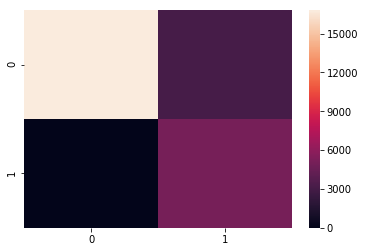

Learning Rate:[0.9779754323328191]
epoch3
train loss: 1.7313148418907076e-05
Learning Rate:[0.9140576474687263]
epoch4
train loss: 1.7405556718586013e-05
valid loss: 1.6725862224120647e-05
accuracy: 87.91199922561646 %
saved


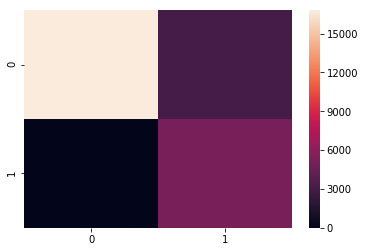

Learning Rate:[0.8145033635316129]
epoch5
train loss: 1.6840946045704186e-05
Learning Rate:[0.6890576474687263]
epoch6
train loss: 1.6658594176988117e-05
valid loss: 1.638430512684863e-05
accuracy: 88.21199536323547 %
saved


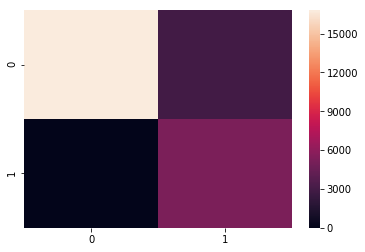

Learning Rate:[0.55]
epoch7
train loss: 1.6414000128861517e-05
Learning Rate:[0.41094235253127376]
epoch8
train loss: 1.6338046407327056e-05
valid loss: 1.610213985259179e-05
accuracy: 88.40799927711487 %
saved


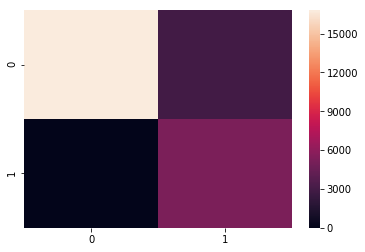

Learning Rate:[0.2854966364683872]
epoch9
train loss: 1.6151816453202628e-05
Learning Rate:[0.18594235253127372]
epoch10
train loss: 1.6086716641439125e-05
valid loss: 1.5996190995792858e-05
accuracy: 88.53600025177002 %
saved


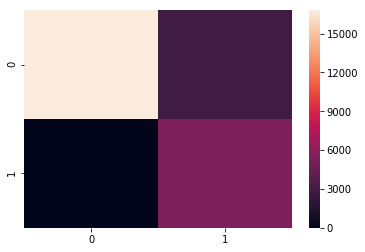

Learning Rate:[0.12202456766718092]
epoch11
train loss: 1.605244142410811e-05
Learning Rate:[0.1]
epoch12
train loss: 1.605530451342929e-05
valid loss: 1.59324990818277e-05
accuracy: 88.60399723052979 %
saved


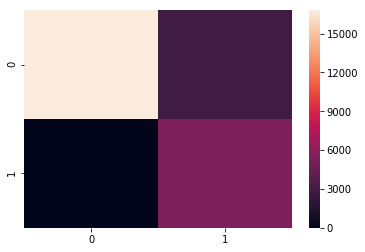

Learning Rate:[0.12202456766718081]
epoch13
train loss: 1.6087265976238996e-05
Learning Rate:[0.1859423525312736]
epoch14
train loss: 1.6135127225425094e-05
valid loss: 1.5793833881616592e-05
accuracy: 88.72799873352051 %
saved


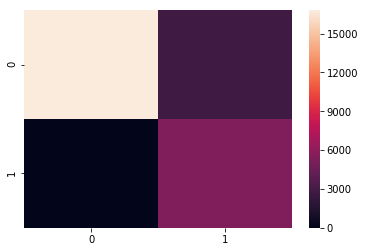

Learning Rate:[0.2854966364683871]
epoch15
train loss: 1.6192438124562614e-05
Learning Rate:[0.41094235253127365]
epoch16
train loss: 1.6215979485423304e-05
valid loss: 1.5611847629770637e-05
accuracy: 88.90399932861328 %
saved


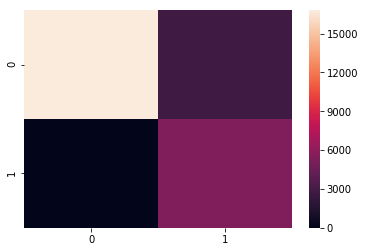

Learning Rate:[0.5499999999999999]
epoch17
train loss: 1.6114054233185016e-05
Learning Rate:[0.6890576474687262]
epoch18
train loss: 1.581549076945521e-05
valid loss: 1.5370540495496243e-05
accuracy: 89.18399810791016 %
saved


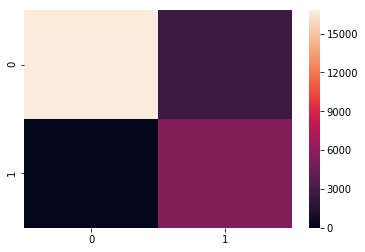

Learning Rate:[0.8145033635316128]
epoch19
train loss: 1.532626811240334e-05
Learning Rate:[0.9140576474687263]
epoch20
train loss: 1.4772764188819565e-05
valid loss: 1.4646118870587088e-05
accuracy: 89.97599482536316 %
saved


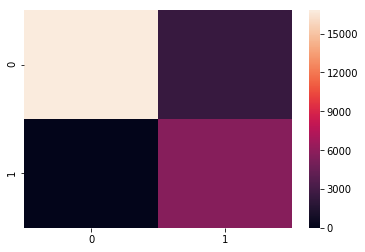

Learning Rate:[0.9779754323328191]
epoch21
train loss: 1.530637382529676e-05
Learning Rate:[1.0]
epoch22
train loss: 1.6492067516082898e-05
valid loss: 1.6117797713377513e-05
accuracy: 88.29999566078186 %


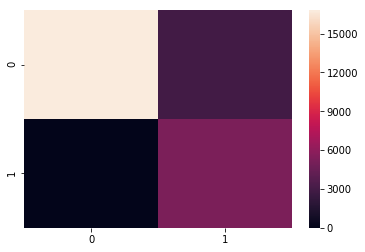

Learning Rate:[0.9779754323328191]
epoch23
train loss: 1.6278323528240435e-05
Learning Rate:[0.9140576474687266]
epoch24
train loss: 1.593113483977504e-05
valid loss: 1.5452769730472937e-05
accuracy: 89.31999802589417 %


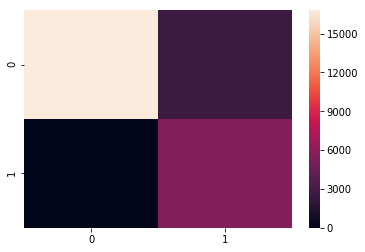

Learning Rate:[0.814503363531613]
epoch25
train loss: 1.528820939711295e-05
Learning Rate:[0.6890576474687264]
epoch26
train loss: 1.4390242540684994e-05
valid loss: 1.3909952031099238e-05
accuracy: 91.72399640083313 %
saved


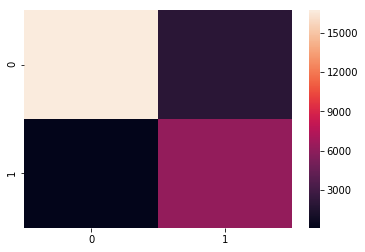

Learning Rate:[0.5500000000000002]
epoch27
train loss: 1.388057989970548e-05
Learning Rate:[0.41094235253127376]
epoch28
train loss: 1.3656293958774768e-05
valid loss: 1.3517643310478888e-05
accuracy: 91.8239951133728 %
saved


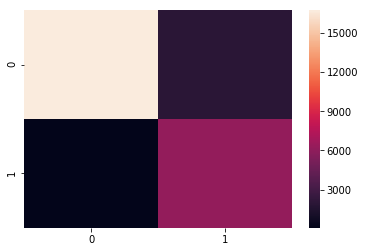

Learning Rate:[0.2854966364683872]
epoch29
train loss: 1.3518642845156137e-05
Learning Rate:[0.18594235253127375]
epoch30
train loss: 1.34348010760732e-05
valid loss: 1.3379361007537227e-05
accuracy: 91.81199669837952 %


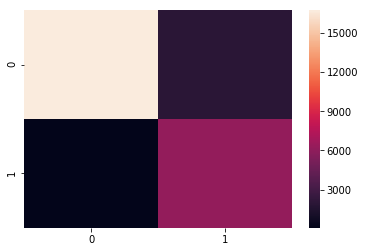

Learning Rate:[0.12202456766718096]
epoch31
train loss: 1.3383566511038225e-05
Learning Rate:[0.1]
epoch32
train loss: 1.3346955711313058e-05
valid loss: 1.3290426977619063e-05
accuracy: 91.74000024795532 %


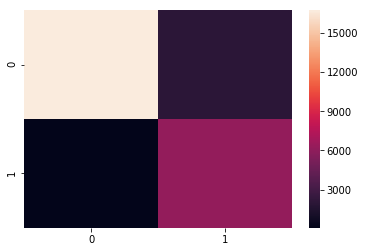

Learning Rate:[0.12202456766718087]
epoch33
train loss: 1.33142484628479e-05
Learning Rate:[0.18594235253127356]
epoch34
train loss: 1.3305380889505614e-05
valid loss: 1.3277905964059755e-05
accuracy: 91.15599989891052 %


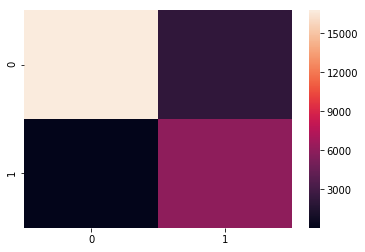

Learning Rate:[0.28549663646838697]
epoch35
train loss: 1.3533817764255218e-05
Learning Rate:[0.4109423525312734]
epoch36
train loss: 1.3344126273295842e-05
valid loss: 1.3173508705222048e-05
accuracy: 91.975998878479 %
saved


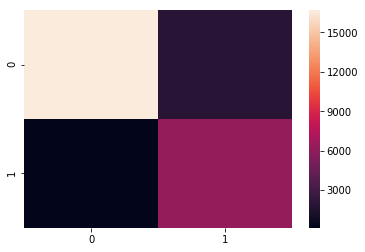

Learning Rate:[0.5499999999999998]
epoch37
train loss: 1.301483644056134e-05
Learning Rate:[0.6890576474687261]
epoch38
train loss: 1.320548471994698e-05
valid loss: 1.3206010407884605e-05
accuracy: 91.93199872970581 %


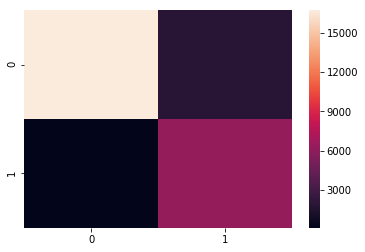

Learning Rate:[0.8145033635316128]
epoch39
train loss: 1.268204505322501e-05
Learning Rate:[0.9140576474687262]
epoch40
train loss: 1.380958201480098e-05
valid loss: 1.2737496945192106e-05
accuracy: 90.21999835968018 %


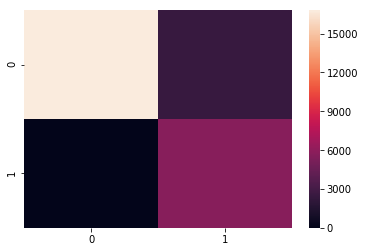

Learning Rate:[0.977975432332819]
epoch41
train loss: 2.8124508389737457e-05
Learning Rate:[1.0]
epoch42
train loss: 1.8061835362459533e-05
valid loss: 1.7156484318547882e-05
accuracy: 87.56799697875977 %


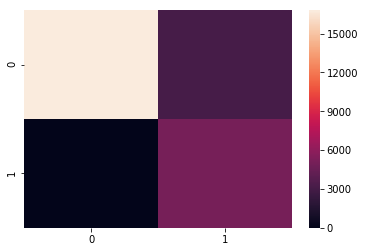

Learning Rate:[0.9779754323328195]
epoch43
train loss: 1.7093305359594524e-05
Learning Rate:[0.9140576474687264]
epoch44
train loss: 1.690479984972626e-05
valid loss: 1.6649410099489614e-05
accuracy: 87.72799968719482 %


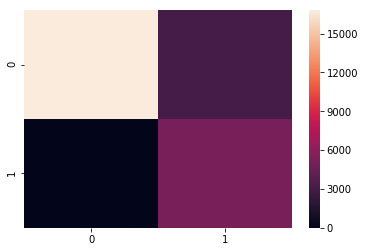

Learning Rate:[0.8145033635316131]
epoch45
train loss: 1.686098039499484e-05
Learning Rate:[0.6890576474687273]
epoch46
train loss: 1.6833462723298e-05
valid loss: 1.6660125766065903e-05
accuracy: 88.03199529647827 %


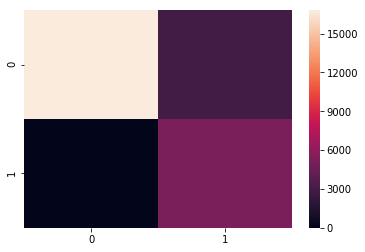

Learning Rate:[0.5500000000000003]
epoch47
train loss: 1.680145760474261e-05
Learning Rate:[0.41094235253127387]
epoch48
train loss: 1.676839019637555e-05
valid loss: 1.667691867623944e-05
accuracy: 88.09999823570251 %


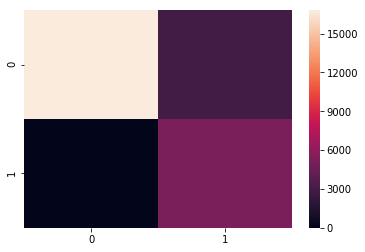

Learning Rate:[0.28549663646838663]
epoch49
train loss: 1.6740492355893366e-05
Learning Rate:[0.1859423525312738]


In [20]:
# Training Loop 

highest = 0
for k in range(50):
    running_loss= 0 
    corrects = 0
    #Train
    for inp, target in Train:
        optimizer.zero_grad()
        inp = inp.cuda()
        output = model.forward(inp.float())
        loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) 
        #loss = CrossEntropy(output, target.float().reshape(output.shape).cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss/len(target)  
    if k % 1==0: 
        print("epoch{}".format(k))
        print("train loss: {}".format(running_loss))    
    running_loss= 0 
    # Added the option of just running the Training step for the first few epochs.
    if k > 1:
        # Validate. 
        for inp, target in Valid:
            inp = inp.cuda()
            output = model.forward(inp.float())
            loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) 
            #Track Epoch Loss
            running_loss += loss/len(target)
            a = (output>0.5) 
            b= target.reshape(output.shape).cuda()>0.5 
        
        #Print out. 
        if k % 2 ==0: 
            print("valid loss: {}".format(running_loss))
            print("accuracy: {} %".format((a==b).float().mean().item()*100))
            if ((a==b).float().mean().item()*100)> highest:
                highest = ((a==b).float().mean().item()*100)
                #Save out model that achieves best accuracy. 
                torch.save(model.state_dict(), './ModelSave1.pt')
                print("saved")
            sns.heatmap(confusion_matrix(a.cpu().numpy(),b.cpu().numpy()))
            plt.show()
            
    print("Learning Rate:{}".format(scheduler.get_lr()))
    scheduler.step() 

# Evaluate Model
 Load up the best performing model. Run the model and Plot the results. 

In [5]:
model2 = Classifier(6,6,1)
model2.load_state_dict(torch.load('./ModelSave1.pt'))
model2.cuda()

df = pd.read_pickle("Reduced.pkl")
df3 = pd.read_pickle("Reduced3.pkl")
df.append(df3)
#Load into Torch Dataset. 
Input = torch.tensor(InpScaler.transform(df[LabelList].values))
Output = torch.tensor(df['Labels'].values)

MainDataSet = torch.utils.data.TensorDataset(Input, Output)
Main = torch.utils.data.DataLoader(MainDataSet,batch_size = 200000,num_workers = 1)
full_results = torch.Tensor()
#Run Model over the batches. 
for inp, Label in Main:
    inp = inp.cuda()
    output = model2.forward(inp.float())
    
    third_tensor = torch.cat((inp.cpu().float(),output.cpu().float()), 1)
    third_tensor = torch.cat((third_tensor,Label.reshape(output.shape).float()), 1)
    full_results = torch.cat((full_results,third_tensor),0)

In [9]:
torch.save(model2.cpu(),'InferenceReady.pt')

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


PicklingError: Can't pickle <class '__main__.Classifier'>: it's not the same object as __main__.Classifier

<IPython.core.display.Javascript object>


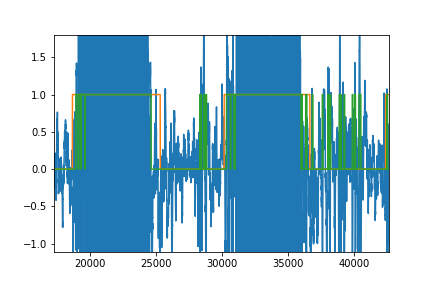

In [38]:
%matplotlib notebook
third_tensor.detach().numpy()
plt.plot(third_tensor[:,0].detach().numpy())
plt.plot(third_tensor[:,-1].detach().numpy())         
plt.plot(third_tensor[:,-2].detach().numpy()>0.5) 


<IPython.core.display.Javascript object>


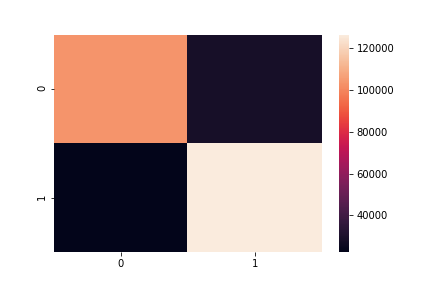

In [39]:
#Confusion Plot. 
plt.figure()

full_results[:,-2] = full_results[:,-2]>0.5
sns.heatmap(confusion_matrix(full_results[:,-2].detach().numpy(),full_results[:,-1].detach().numpy()))
plt.show()

<IPython.core.display.Javascript object>


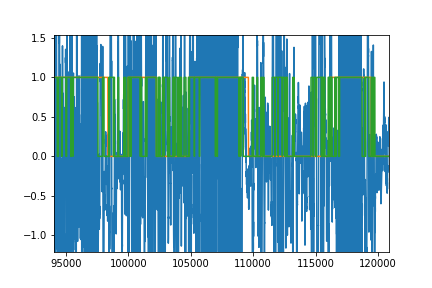

In [40]:
#Time Series
plt.figure()
plt.plot(full_results[:,0].detach().numpy())
plt.plot(full_results[:,-1].detach().numpy())
plt.plot(full_results[:,-2].detach().numpy())
plt.show()